In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pysqkit as sq
from itertools import product, combinations
from matplotlib.lines import Line2D
from IPython.display import display, Latex

### Set some matplotlib parameters

In [2]:
plt.rcParams['figure.dpi'] = 100

### Define some utility functions

In [3]:
def _get_sys_states(system, comp_states):
    _energies, _states = list(zip(*[system.state(state_label) for state_label in comp_states]))
    _energies, _states = np.array(_energies), np.array(_states)
    sys_states = xr.DataArray(_states, dims=['state', 'basis_ind'], coords=dict(state=comp_states, energy=(["state"], _energies)))
    sys_states['energy'] = sys_states.energy - sys_states.energy[0]
    return sys_states

In [4]:
transmon = sq.qubits.SimpleTransmon(
    label='transmon', 
    max_freq = 6, 
    anharm = -0.3, 
    dim_hilbert = 5
)

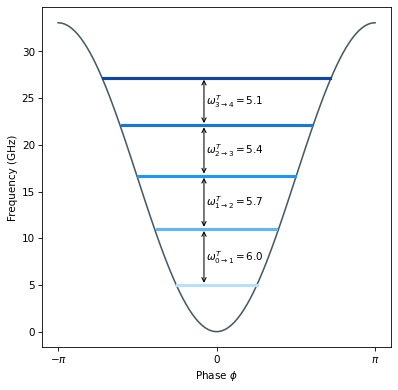

In [5]:
levels = range(5)
_ref_energy = 5 # Set some reference frequency for the ground state such that the plot looks nicer
transmon_energies = xr.DataArray(transmon.eig_energies(levels=levels) + 5, dims=['level'], coords=dict(level=levels))
phases = np.linspace(-np.pi,np.pi, 100)
_potential = (transmon.joseph_energy + transmon.potential(phases))
potential = xr.DataArray(_potential, dims=['phase'], coords=dict(phase=phases))

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=75)
ax.plot(potential.phase, potential, '-', color='#455a64')

for level, color in zip(levels, ['#bbdefb', '#64b5f6', '#2196f3', '#1976d2', "#0d47a1"]):
    energy = transmon_energies.sel(level=level).data
    sel_phases = potential.phase.where(potential < energy, drop=True)
    ax.plot([sel_phases.min(), sel_phases.max()], [energy, energy], color=color, lw=3)
    if level > 0:
        prev_energy = transmon_energies.sel(level=level-1).data
        ax.annotate(s='', xy=(-0.25, prev_energy), xytext=(-0.25,energy), arrowprops=dict(arrowstyle='<->'))
        ax.text(-0.2, 0.5*(energy + prev_energy), r'$\omega^{{T}}_{{{} \rightarrow {}}} = {:.2}$'.format(level-1, level, energy-prev_energy), va='center', rotation='horizontal')
    
ax.set_xlabel('Phase $\phi$')
ax.set_ylabel('Frequency (GHz)')
ax.set_xticks([-np.pi, 0, np.pi])
ax.set_xticklabels([r'$-\pi$', '0', r'$\pi$'])
plt.show()

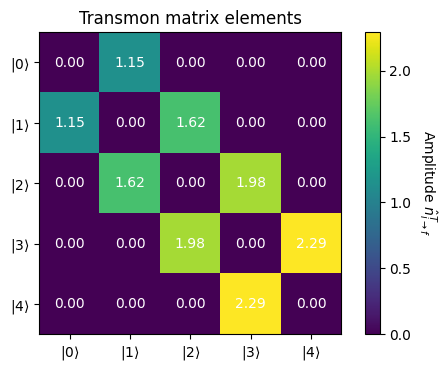

In [6]:
levels = range(5)
level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in levels]
transmon_mat_elems = transmon.mat_elements(operator='charge_op', levels=levels, as_xarray=True)

fig, ax = plt.subplots()
plt.imshow(np.abs(transmon_mat_elems.data), cmap='viridis')

for in_level, out_level in product(levels, repeat=2):
    amplitude = abs(transmon_mat_elems.sel(in_level=in_level, out_level=out_level))
    ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")
    
ax.set_xticks(levels)
ax.set_yticks(levels)
ax.set_xticklabels(level_labels)
ax.set_yticklabels(level_labels)

cbar = plt.colorbar()
cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{T}_{i \rightarrow f}$", rotation=-90, va="bottom")

ax.set_title('Transmon matrix elements')

plt.show()

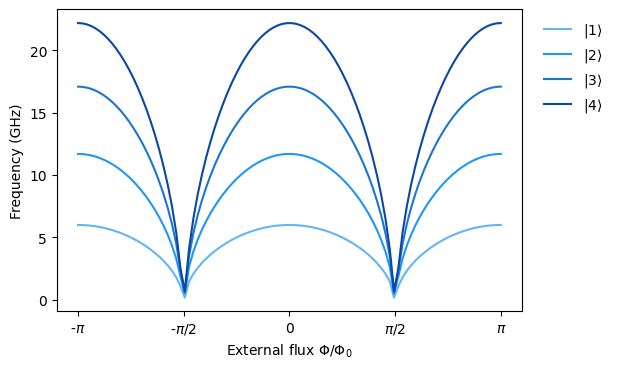

In [7]:
fluxbiases = np.linspace(-1, 1, 100)
levels = np.arange(5)
init_ext_flux = transmon.ext_flux

_energies = []
for fluxbias in fluxbiases:
    transmon.ext_flux = fluxbias
    _energies.append(transmon.eig_energies(levels=levels))
transmon.ext_flux = init_ext_flux
    
flux_scan = xr.DataArray(_energies, dims=['ext_flux', 'level'], coords=dict(ext_flux=fluxbiases, level=levels))

fig, ax = plt.subplots()
for level, color in zip(levels[1:], ['#64b5f6', '#2196f3', '#1976d2', "#0d47a1"]):
    ax.plot(flux_scan.ext_flux, flux_scan.sel(level=level), color=color, label=r'$\left|{}\right\rangle$'.format(level))

ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_xticklabels([r'-$\pi$', '-$\pi$/2', r'0',  '$\pi$/2', r'$\pi$'])
ax.set_xlabel(r'External flux $\Phi/\Phi_0$')
ax.set_ylabel(r'Frequency (GHz)')

ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.show()

In [8]:
fluxonium = sq.qubits.Fluxonium(
    label='fluxonium',
    joseph_energy=5.900, 
    charge_energy=0.975, 
    induct_energy=0.455,
    flux = 0.5
)
fluxonium.diagonalize_basis(5)

In [9]:
fluxonium_tran_freqs = np.diff(fluxonium.eig_energies(), 1)
for level in range(3):
    display(Latex(r'$\omega^{{f}}_{{{} \rightarrow {}}}$ = {:.3f} GHz'.format(level, level+1, fluxonium_tran_freqs[level])))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

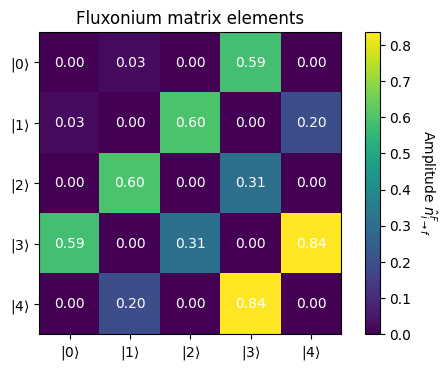

In [10]:
levels = range(5)
level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in levels]
fluxonium_mat_elems = fluxonium.mat_elements(operator='charge_op', levels=levels, as_xarray=True)

fig, ax = plt.subplots()
plt.imshow(np.abs(fluxonium_mat_elems.data), cmap='viridis')

for in_level, out_level in product(levels, repeat=2):
    amplitude = abs(fluxonium_mat_elems.sel(in_level=in_level, out_level=out_level))
    ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")
    
ax.set_xticks(levels)
ax.set_yticks(levels)
ax.set_xticklabels(level_labels)
ax.set_yticklabels(level_labels)

cbar = plt.colorbar()
cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

ax.set_title('Fluxonium matrix elements')

plt.show()

# Inspecting the coupled transmon-fluxonium system

In [11]:
bare_system = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=0)
comp_states = [''.join(qubit_states) for qubit_states in list(product('0123', repeat=2))]

_eig_energies = bare_system.eig_energies()
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

state_energies = xr.DataArray(_eig_energies[level_inds.data], dims=['state'], coords=dict(state=level_inds.state.data))
state_energies -= state_energies.sel(state='00')

for state in ['01', '02', '10', '11']:
    display(Latex(r'$\omega_{{{}}}$ = {:.3f} GHz'.format(state, float(state_energies.sel(state=state)))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

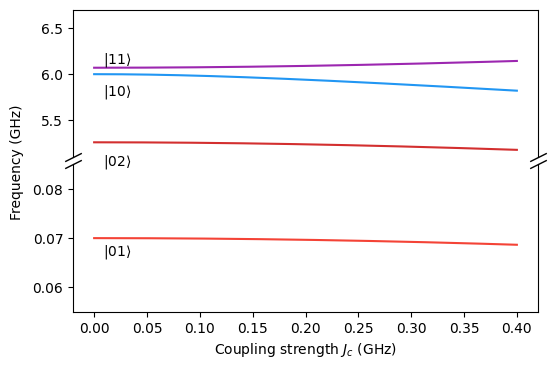

In [12]:
coupling_strengths = np.linspace(0, 0.4, 200)

_eig_energies = bare_system.eig_energies()
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

_energies = []
for strength in coupling_strengths:
    _sys = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=strength)
    eig_energies = _sys.eig_energies(levels=level_inds.data)
    _energies.append(eig_energies - eig_energies[0])
    
energies = xr.DataArray(_energies, dims=['coup_str', 'state'], coords=dict(coup_str=coupling_strengths, state=level_inds.state)) 

fig, (top_ax, bot_ax) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05) 

bot_ax.plot(energies.coup_str, energies.sel(state='01'), color='#f44336')

for state, color in zip(['02', '10', '11'], ['#d32f2f', '#2196f3', '#9c27b0']):
    top_ax.plot(energies.coup_str, energies.sel(state=state), color=color)

bot_ax.set_ylim(0.055, 0.085)
top_ax.set_ylim(5.1, 6.7)

top_ax.spines['bottom'].set_visible(False)
bot_ax.spines['top'].set_visible(False)
top_ax.tick_params(axis='x', bottom=False)
top_ax.tick_params(labeltop=False)
bot_ax.xaxis.tick_bottom()

d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
bot_ax.plot([0, 1], [1, 1], transform=bot_ax.transAxes, **kwargs)
top_ax.plot([0, 1], [0, 0], transform=top_ax.transAxes, **kwargs)

bot_ax.set_xlabel(r"Coupling strength $J_{c}$ (GHz)")
fig.text(0.02, 0.5, 'Frequency (GHz)', va='center', rotation='vertical')

fig.text(0.175, 0.275, r'$\left|01\right\rangle$', va='center', rotation='horizontal')
fig.text(0.175, 0.5, r'$\left|02\right\rangle$', va='center', rotation='horizontal')
fig.text(0.175, 0.675, r'$\left|10\right\rangle$', va='center', rotation='horizontal')
fig.text(0.175, 0.755, r'$\left|11\right\rangle$', va='center', rotation='horizontal')
    
plt.show()

In [13]:
_transition_freqs = []
coup_strengths = np.linspace(0, 0.35, 40)

_eig_energies = bare_system.eig_energies()
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

for coup_strength in coup_strengths:
    _sys = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=coup_strength)
    energies = _sys.eig_energies(levels=level_inds.data)
    energies -= energies[0]
    _transition_freqs.append(energies[:,np.newaxis] - energies)

trans_freq_scan = xr.DataArray(
    _transition_freqs, 
    dims=['coup_str', 'out_state', 'in_state'], 
    coords=dict(
        coup_str=coup_strengths, 
        out_state=level_inds.state.data, 
        in_state=level_inds.state.data,
    )
)

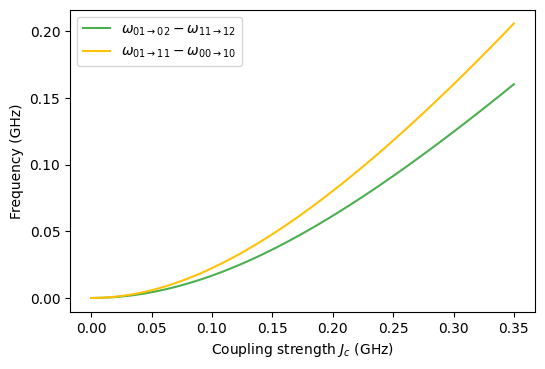

In [14]:
fig, ax = plt.subplots()

ax.plot(trans_freq_scan.coup_str, trans_freq_scan.sel(in_state='01', out_state='02') - trans_freq_scan.sel(in_state='11', out_state='12'), label=r'$\omega_{01\rightarrow02}-\omega_{11\rightarrow12}$', color='#4caf50')
ax.plot(trans_freq_scan.coup_str, trans_freq_scan.sel(in_state='01', out_state='11') - trans_freq_scan.sel(in_state='00', out_state='10'), label=r'$\omega_{01\rightarrow11}-\omega_{00\rightarrow10}$', color='#ffc107')

ax.set_ylabel('Frequency (GHz)')
ax.set_xlabel(r'Coupling strength $J_{c}$ (GHz)')
plt.legend()
plt.show()

In [15]:
_mat_elem_amplitudes = []
coup_strengths = np.linspace(0, 0.35, 40)

q_labels = [qubit.label for qubit in bare_system]

_eig_energies = bare_system.eig_energies()
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

for coup_strength in coup_strengths:
    _sys = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=coup_strength)
    _elem_amps = []
    for q_label in q_labels:
        _elem_amps.append(np.abs(_sys.mat_elements(_sys[q_label].charge_op(), levels=level_inds.data)))
    _mat_elem_amplitudes.append(_elem_amps)

mat_elem_amplitude_scan = xr.DataArray(
    _mat_elem_amplitudes, 
    dims=['coup_str', 'qubit', 'out_state', 'in_state'], 
    coords=dict(
        coup_str=coup_strengths, 
        qubit=q_labels,
        out_state=level_inds.state.data, 
        in_state=level_inds.state.data
    )
)

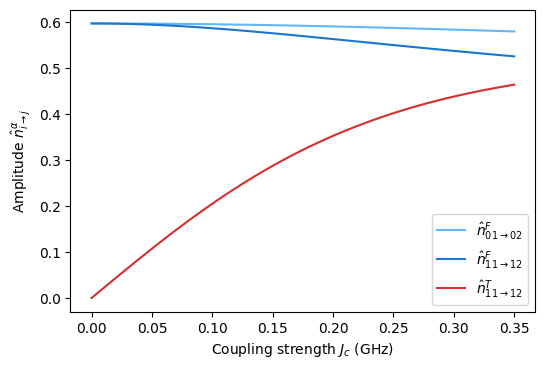

In [16]:
fig, ax = plt.subplots()

ax.plot(mat_elem_amplitude_scan.coup_str, mat_elem_amplitude_scan.sel(qubit='fluxonium', in_state='01', out_state='02'), label=r'$\hat{n}^{F}_{01 \rightarrow 02}$', color='#64b5f6')
ax.plot(mat_elem_amplitude_scan.coup_str, mat_elem_amplitude_scan.sel(qubit='fluxonium', in_state='11', out_state='12'), label=r'$\hat{n}^{F}_{11 \rightarrow 12}$', color='#1976d2')

ax.plot(mat_elem_amplitude_scan.coup_str, mat_elem_amplitude_scan.sel(qubit='transmon', in_state='11', out_state='12'), label=r'$\hat{n}^{T}_{11 \rightarrow 12}$', color='#d32f2f')

ax.set_ylabel(r'Amplitude $\hat{n}^{\alpha}_{i\rightarrow j}$')
ax.set_xlabel(r'Coupling strength $J_{c}$ (GHz)')

plt.legend()
plt.show()

In [17]:
system = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=0.2)

In [19]:
_eig_energies = bare_system.eig_energies()
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

eig_energies = system.eig_energies(levels=level_inds.data)
eig_energies -= eig_energies[0]
state_energies = xr.DataArray(eig_energies, dims=['state'], coords=dict(state=level_inds.state.data))

bare_eig_energies = _eig_energies[level_inds.data]
bare_state_energies = xr.DataArray(bare_eig_energies - bare_eig_energies[0], dims=['state'], coords=dict(state=level_inds.state.data))

trans_freqs = xr.DataArray(
    eig_energies[:,np.newaxis] - eig_energies, 
    dims=['out_state', 'in_state'], 
    coords=dict(
        out_state=level_inds.state.data, 
        in_state=level_inds.state.data
    )
)

mat_elem_amps = xr.DataArray(
    [np.abs(_sys.mat_elements(qubit.charge_op(), levels=level_inds.data)) for qubit in system],
    dims=['qubit', 'out_state', 'in_state'], 
    coords=dict( 
        qubit=q_labels,
        out_state=level_inds.state.data, 
        in_state=level_inds.state.data
    )
)

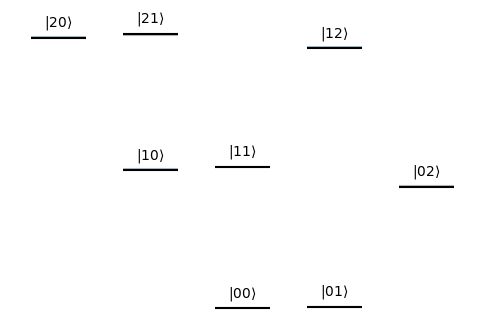

In [20]:
fig, ax = plt.subplots()

for state in ['00', '01', '02', '10', '11', '12', '20', '21']:
    transmon_state, fluxonium_state = (int(state_label) for state_label in state)
    exc_ind = fluxonium_state - transmon_state
    bare_energy = bare_state_energies.sel(state=state)
    energy = state_energies.sel(state=state)
    ax.hlines(bare_energy, xmin=exc_ind-0.3, xmax=exc_ind+0.3, color='#b0bec5')
    ax.hlines(energy, xmin=exc_ind-0.3, xmax=exc_ind+0.3)
    ax.text(exc_ind, energy+0.25, r'$\left|{}\right\rangle$'.format(state), va='bottom', ha='center', rotation='horizontal')
    
ax.axis('off')
plt.show()

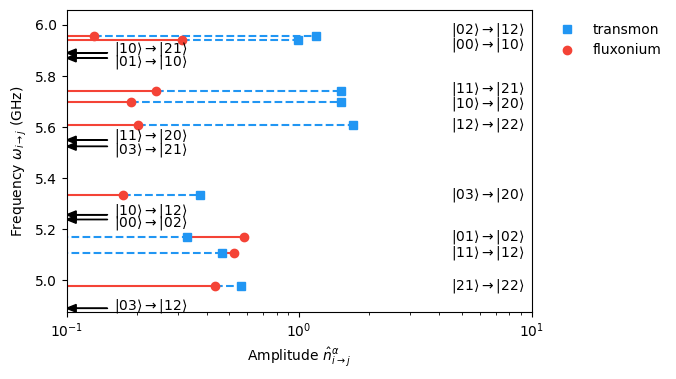

In [21]:
_min_mat_elem_bound = 1e-1
_mim_freq_bound = 4
_max_freq_bound = 6

fig, ax = plt.subplots()

_labeled_trans = dict()
_unlabeled_trans = dict()

_markers = dict(transmon='s', fluxonium='o')
_colors = dict(transmon='#2196f3', fluxonium = '#f44336')
_linestyles = dict(transmon='--', fluxonium='-')

_sel_states = ['00', '01', '02', '03', '10', '11', '12', '20', '21', '22']

for in_state, out_state in combinations(_sel_states, 2):
    trans_freq = float(trans_freqs.sel(in_state=in_state, out_state=out_state))
    if trans_freq < _max_freq_bound and trans_freq > _mim_freq_bound:
        amp_vals = mat_elem_amps.sel(in_state=in_state, out_state=out_state)
        if any(amp_vals > _min_mat_elem_bound):
            amp_vals = amp_vals.sortby(amp_vals)
            min_val, max_val = amp_vals.data
            qubits = amp_vals.qubit.data
            for xmin, xmax, qubit in zip([0, min_val], [min_val, max_val], qubits):
                ax.hlines(trans_freq, xmin=xmin, xmax=xmax, color=_colors[qubit], linestyles=_linestyles[qubit])
                ax.plot([xmax], [trans_freq], marker=_markers[qubit], markersize=6, color=_colors[qubit])
                _labeled_trans[trans_freq] = (in_state, out_state)
        else:
            _unlabeled_trans[trans_freq] = (in_state, out_state)
                    
                    
offsets={('00', '10') : -0.02, ('02', '12') : 0.02, ('11', '21') : 0.01, ('10', '20') : -0.01}         
for trans_freq, states in _labeled_trans.items():
    ax.text(4.5, trans_freq + offsets.get(states, 0), r'$\left|{}\right\rangle \rightarrow \left|{}\right\rangle$'.format(*states), va='center', rotation='horizontal')
    
offsets={('10', '12') : 0.015, ('00', '02') : -0.015, ('10', '21') : 0.015, ('01', '10') : -0.015,  ('11', '20') : 0.015, ('03', '21') : -0.015,  ('03', '12') : 0.01}
for trans_freq, states in _unlabeled_trans.items():
    if states != ('20', '22'):
        ax.arrow(0.15, trans_freq, -0.04, 0, head_width=0.03, head_length=0.01, fc='k', ec='k')
        ax.text(0.16, trans_freq + offsets.get(states, 0), r'$\left|{}\right\rangle \rightarrow \left|{}\right\rangle$'.format(*states), va='center', rotation='horizontal')


ax.set_ylim(min(_labeled_trans.keys())-0.1, max(_labeled_trans.keys())+0.1)    
ax.set_xlim(_min_mat_elem_bound, 10)
ax.set_xscale('log')

legend_handles = [Line2D([0], [0], color=_colors[qubit], marker=_markers[qubit], markersize=6, label=qubit, linestyle='None') for qubit in ['transmon', 'fluxonium']]
ax.legend(handles=legend_handles, bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
ax.set_xlabel(r'Amplitude $\hat{n}^{\alpha}_{i\rightarrow j}$')
ax.set_ylabel(r'Frequency $\omega_{i\rightarrow j}$ (GHz)')
plt.show()

# Flux-pulsing based CZ gate

The other option we are considering is to perform a CZ gate by flux-tuning the transmon. Let us first take a look at the energy level diagram of our system

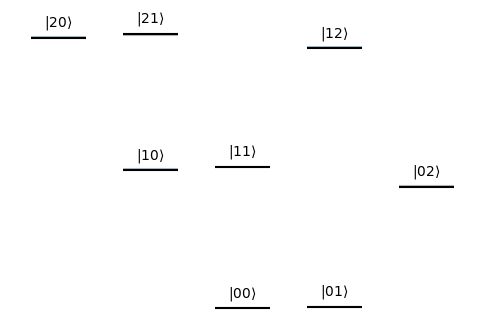

In [25]:
fig, ax = plt.subplots()

for state in ['00', '01', '02', '10', '11', '12', '20', '21']:
    transmon_state, fluxonium_state = (int(state_label) for state_label in state)
    exc_ind = fluxonium_state - transmon_state
    bare_energy = bare_state_energies.sel(state=state)
    energy = state_energies.sel(state=state)
    ax.hlines(bare_energy, xmin=exc_ind-0.3, xmax=exc_ind+0.3, color='#b0bec5')
    ax.hlines(energy, xmin=exc_ind-0.3, xmax=exc_ind+0.3)
    ax.text(exc_ind, energy+0.25, r'$\left|{}\right\rangle$'.format(state), va='bottom', ha='center', rotation='horizontal')
    
ax.axis('off')
plt.show()

We can observe that the frequency of $\left|11\right\rangle$ is above that of  $\left|02\right\rangle$ for our parameters and in specific they are detuned by $\approx700$ MHz. Given the flux-tunability of the transmon we can perfom a flux sweep and look at the transition frequencies (from $\left|00\right\rangle$), which we perform below

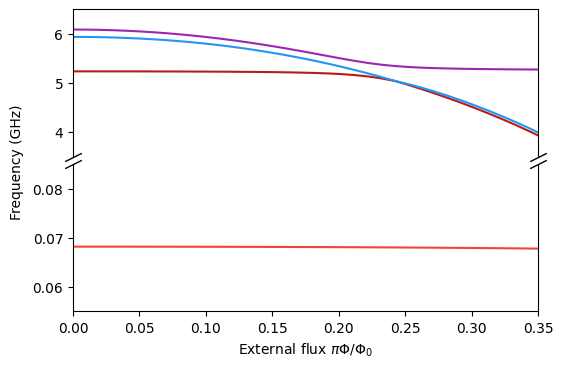

In [22]:
fluxbiases = np.linspace(0, 1, 100)
levels = np.arange(5)
init_ext_flux = system['transmon'].ext_flux

_eig_energies = bare_system.eig_energies()
_ground_state_energy = _eig_energies[0]
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

_energies = []
for fluxbias in fluxbiases:
    system['transmon'].ext_flux = fluxbias
    _energies.append(system.eig_energies(levels=level_inds.data) - _ground_state_energy)
system['transmon'].ext_flux = init_ext_flux
    
flux_scan = xr.DataArray(_energies, dims=['ext_flux', 'state'], coords=dict(ext_flux=fluxbiases, state=level_inds.state.data))

fig, (top_ax, bot_ax) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.05) 

for state, color in zip(['01'], ['#f44336']):
    bot_ax.plot(flux_scan.ext_flux, flux_scan.sel(state=state), color=color)

for state, color in zip(['02',  '10', '11'], ['#b71c1c', '#2196f3', '#9c27b0']):
    top_ax.plot(flux_scan.ext_flux, flux_scan.sel(state=state), color=color)

top_ax.set_ylim(3.5, 6.5)
bot_ax.set_ylim(0.055, 0.085)
bot_ax.set_xlim(0, 0.35)

top_ax.spines['bottom'].set_visible(False)
bot_ax.spines['top'].set_visible(False)
top_ax.tick_params(axis='x', bottom=False)
top_ax.tick_params(labeltop=False)
bot_ax.xaxis.tick_bottom()

d = .5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
bot_ax.plot([0, 1], [1, 1], transform=bot_ax.transAxes, **kwargs)
top_ax.plot([0, 1], [0, 0], transform=top_ax.transAxes, **kwargs)

bot_ax.set_xlabel(r'External flux $\pi\Phi/\Phi_0$')
fig.text(0.02, 0.5, 'Frequency (GHz)', va='center', rotation='vertical')
    
plt.show()

We observe an avoided crossing between $\left|11\right\rangle$ is above that of  $\left|02\right\rangle$. Zooming in around that area

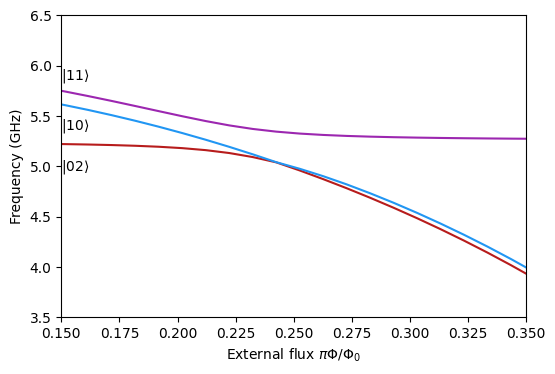

In [48]:
fluxbiases = np.linspace(0, 1, 100)
init_ext_flux = system['transmon'].ext_flux

_eig_energies = bare_system.eig_energies()
_ground_state_energy = _eig_energies[0]
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

_energies = []
for fluxbias in fluxbiases:
    system['transmon'].ext_flux = fluxbias
    _energies.append(system.eig_energies(levels=level_inds.data) - _ground_state_energy)
system['transmon'].ext_flux = init_ext_flux
    
flux_scan = xr.DataArray(_energies, dims=['ext_flux', 'state'], coords=dict(ext_flux=fluxbiases, state=level_inds.state.data))

fig, ax = plt.subplots()

for state, color in zip(['02',  '10', '11'], ['#b71c1c', '#2196f3', '#9c27b0']):
    ax.plot(flux_scan.ext_flux, flux_scan.sel(state=state), color=color)

ax.set_ylim(3.5, 6.5)
ax.set_xlim(0.15, 0.35)

ax.text(0.15, 5, r'$\left|02\right\rangle$', va='center', ha='left', rotation='horizontal')
ax.text(0.15, 5.4, r'$\left|10\right\rangle$', va='center', ha='left', rotation='horizontal')
ax.text(0.15, 5.9, r'$\left|11\right\rangle$', va='center', ha='left', rotation='horizontal')


ax.set_xlabel(r'External flux $\pi\Phi/\Phi_0$')
ax.set_ylabel('Frequency (GHz)')
    
plt.show()

we see the avoided crossing between $\left|11\right\rangle$ and $\left|02\right\rangle$ occurs at the flux point of $\pi\Phi/\Phi_0\approx 0.24$ fluxbias applied to the transmon. At that point the frequency of the $\left|11\right\rangle$ begins to deviate from the sum of the frequencies of $\left|01\right\rangle$ and $\left|10\right\rangle$ (more than it already has). In particular we can define again the effective coupling $\zeta$ = $\omega_{11}$ - $\omega_{10}$ - $\omega_{01}$ (as a reminder we have fixed the ground state frequency as a reference). Note that this is also the same quantity that characterizes the crosstalk.

In [78]:
_eig_energies = bare_system.eig_energies()
_ground_state_energy = _eig_energies[0]
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

init_ext_flux = system['transmon'].ext_flux
system['transmon'].ext_flux = 0.24
state_energies = xr.DataArray(system.eig_energies(levels=level_inds.data) - _ground_state_energy, dims=['state'], coords=dict(state=level_inds.state.data))
system['transmon'].ext_flux = init_ext_flux

eff_coup_str = state_energies.sel(state='11') - state_energies.sel(state='01') - state_energies.sel(state='10')
display(Latex(r'$\zeta$ = {:.3f} GHz'.format(float(eff_coup_str))))

<IPython.core.display.Latex object>

We can estimate the speed limit of a CZ gate relying on this effective coupling strength. The conditional phase acquired during this CZ gate is defined as $\int\varepsilon(t) dt$ = $(2n+1)\pi$. Assuming we just instantly flux-pulse to the interaction point, the gate speed limit is given by $t_{lim}=\pi/\zeta$

In [76]:
display(Latex(r'$t_{{lim}}$ = {:.3f} ns'.format(float(np.pi/eff_coup_str)))) 

<IPython.core.display.Latex object>

We can see that this a very low speed limit, which should not come to a surprise given the large coupling as well as the choice of parameters. However again an issue is the fact we have a large amount of ZZ-crosstalk, which is again characterized by $\zeta$ at no applied fluxbias

In [87]:
_eig_energies = bare_system.eig_energies()
_ground_state_energy = _eig_energies[0]
level_inds = xr.DataArray([bare_system.state_index(state, _eig_energies) for state in comp_states], dims=['state'], coords=dict(state=comp_states))
level_inds = level_inds.sortby(level_inds)

state_energies = xr.DataArray(system.eig_energies(levels=level_inds.data) - _ground_state_energy, dims=['state'], coords=dict(state=level_inds.state.data))

res_crosstalk_str = state_energies.sel(state='11') - state_energies.sel(state='01') - state_energies.sel(state='10')
display(Latex(r'$\zeta^{{\mathrm{{res}}}}$ = {:.3f} GHz'.format(float(res_crosstalk_str))))

<IPython.core.display.Latex object>

And in particular we observe an on-off ratio of this interaction of

In [88]:
display(Latex(r'$\zeta/\zeta^{{\mathrm{{res}}}}$ = {:.3f}'.format(float(eff_coup_str/res_crosstalk_str)))) 

<IPython.core.display.Latex object>

indicating that this is quite a poor gate in practice (given our choice of parameters and assuming we are not using tunable couplers).